In [1]:
## Install required pip packages, import needed libraries, mount google drive in colab notebooks,
## set BASE_DIR, set device to cpu or gpu based on what's available, download dataset

# !pip install -Uqq fastbook ipywidgets nbdev

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
## your drive home will be at /content/gdrive/MyDrive/
## your notebooks might be at /content/gdrive/MyDrive/Colab Notebooks/
# BASE_DIR = "/content/gdrive/MyDrive/Colab Notebooks/"
BASE_DIR = "/home/jovyan/work"

## https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'using device: {device}')

# !export FASTAI_HOME=/home/jovyan/work
path = untar_data(URLs.MNIST_SAMPLE, data=f'{BASE_DIR}/data')
print(f'path.ls: {path.ls()}, path.pwd: {path}')

using device: cuda:0


path.ls: [Path('/home/jovyan/work/data/mnist_sample/train'), Path('/home/jovyan/work/data/mnist_sample/valid'), Path('/home/jovyan/work/data/mnist_sample/labels.csv')], path.pwd: /home/jovyan/work/data/mnist_sample


In [2]:
## How do the pytorch functions cat(), view(), unsqueeze(), sum() and mean() work

# ??torch.cat
# ??torch.view
# ??torch.unsqueeze
# ??torch.sum
# ??torch.mean


a = torch.ones(3, 2)
b = torch.full((1, 2), 7)
c = torch.full((1, 4, 3), 3)
print(f'a: {a}, \nb: {b}, \ncat(): {torch.cat([a, b])}, \nview(): {torch.cat([a, b]).view(-1, 4)}')

## valid values for unsqueeze in this example: -2 to 1
t = tensor([1]*3 + [0]*4)
print(f't: {t}')
print(f'unsqueeze(0): {t.unsqueeze(1)}')
print(f'unsqueeze(1): {t.unsqueeze(0)}')

a, a.sum(), a.mean()

a: tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]), 
b: tensor([[7, 7]]), 
cat(): tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [7., 7.]]), 
view(): tensor([[1., 1., 1., 1.],
        [1., 1., 7., 7.]])
t: tensor([1, 1, 1, 0, 0, 0, 0])
unsqueeze(0): tensor([[1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0]])
unsqueeze(1): tensor([[1, 1, 1, 0, 0, 0, 0]])


(tensor([[1., 1.],
         [1., 1.],
         [1., 1.]]),
 tensor(6.),
 tensor(1.))

In [3]:
## Convert MNIST data in folders to the format we need
## 1. Open each image file as an Image object and convert it to tensors
## 2. Convert a list of 2D tensors to a 3D tensor using stack(), normalise
##     by converting each value to a float and dividing by max pixel value 255
## 3. Concatenate all the tensors of 3s and 7s together and make 28x28 arrays
##     into a 28*28 length list
## 4. Creatae the labels such that we have 1 for image '3' and 0 for image '7'

def filesToStackedTensors(d1, d2):
  t = [tensor(Image.open(f)).to(device) for f in (path/d1/d2).ls().sorted()]
  return torch.stack(t, 0).float()/255

def x_y(stacked_x, stacked_y):
  x = torch.cat([stacked_x, stacked_y]).view(-1, 28*28)
  y = tensor([1]*len(stacked_x) + [0]*len(stacked_y)).unsqueeze(1).to(device)
  return (x, y)

In [4]:
## set the values of train_x, train_y, valid_x and valid_y

train_x, train_y = x_y(filesToStackedTensors('train', '3'), \
                       filesToStackedTensors('train', '7'))
valid_x, valid_y = x_y(filesToStackedTensors('valid', '3'), \
                       filesToStackedTensors('valid', '7'))
# train_x.shape, train_y.shape, valid_x.shape, valid_y.shape
# print(f'x cuda? {train_x.is_cuda}')
# print(f'y cuda? {train_y.is_cuda}')

In [5]:
## How does pytorch function where() work
## https://pytorch.org/docs/stable/generated/torch.where.html

#??torch.where

x = torch.randn(3, 2)
y = torch.ones(3, 2)
print(f'x: {x}, \ny: {y}')
print(torch.where(x > 0, 1.0, 0.0))
print(torch.where(x > 0, x, y))

x: tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]]), 
y: tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[1., 1.],
        [1., 1.],
        [0., 0.]])
tensor([[0.3367, 0.1288],
        [0.2345, 0.2303],
        [1.0000, 1.0000]])


In [36]:
## define functions to represent the model(predictions), loss function(loss) and apply gradient descent algorithm
## n number of times(apply_step & apply_steps)

def predictions(x, w, b):
  r = x@w + b
  # print(f'r.grad_fn: {r.grad_fn}')
  # print(f'r shape: {r.shape}, r: {r[0:4, 0:4]}')
  # sums = (r.sum(1)).unsqueeze(1)
  # print(f'sums.grad_fn: {sums.grad_fn}')
  # print(f'sums shape: {sums.shape}, sums: {sums[0:4]}')
  sig = torch.sigmoid(r)
  # print(f'sig.grad_fn: {sig.grad_fn}')
  # print(f'sig shape: {sig.shape}, sig: {sig[0:4]}')
  # print(f'sig: {sig[0:4]}, sig.sum: {sig.sum()}')
  return sig

def loss_old(preds, y):
  # print(f'preds: {preds[0:5]}')
  # print(f'labels: {y[0:5]}')
  # print(f'x shape: {preds.shape}, y shape: {y.shape}')
  a = (preds - y).abs().mean()
  # print(f'a.grad_fn: {a.grad_fn}')
  # print(f'a: {a}')
  return a

def loss(preds, y):
    return torch.where(y==1, 1-preds, preds).mean()
# loss(predictions(train_x, w, b), train_y)

def apply_step(i, x, y, w, b, lr):
  preds = predictions(x, w, b)
  # print(f'preds.grad_fn: {preds.grad_fn}')
  # l = preds.backward()
  l = loss(preds, y)
  # print(f'l.grad_fn: {l.grad_fn}')
  l.backward()
  # print(f'w after backward: {w[0:1]}')
  # print(f'w grads after backward: {w.grad.shape}, {w.grad[:,0:4]}')
  # print(f'w.grad.data: {w.grad.data[0:3]}')
  # print(f'before b.data: {b.data}')
  # print(f'before b.grad: {b.grad.data}')
  w.data = w.data - (w.grad.data * lr)
  b.data = b.data - (b.grad.data * lr)
  # print(f'after b.grad: {b.grad}')
  w.grad = b.grad = None
  return (w, b, l)

def apply_steps(n, x, y, w, b, lr):
  results = []
  for i in range(n):
    # print(f'before b: {b[0:5]}')
    (w, b, l) = apply_step(i, x, y, w, b, lr)
    results.append(l)
    if(i % 100 == 0): print(f'loss at step({i}): {l}')
    # print(f'after b: {b[0:5]}')
  return (w, b, results)

## put 1 at indices of image tensors where the predictions disagree with the target/label
def differs(x, y, fw, fb):
    p = predictions(x, fw, fb)
    p = torch.where((p>0.9), 1, 0)
    return torch.where(y==1, 1-p, p)

In [37]:
## Initialise parameters(w & b), initialise learning rates(lrs), call gradient descent algorithm

g = torch.Generator()
g.manual_seed(5)
w = torch.randn((784, 1), generator=g).to(device).requires_grad_(True)
# print(f'w cuda? {w.is_cuda}')
# print(f'w shape: {w.shape}, w: {w[0:4, 0:4]}')
b = torch.randn(1, generator=g).to(device).requires_grad_(True)
# print(f'b cuda? {b.is_cuda}')
# print(f'len(b): {len(b)}, b: {b[0:9]}')

# lrs = [0.001, 0.1, 1, 100, 10000, 100000]
lrs = [100]
fw, fb, _ = apply_steps(1, train_x, train_y, w, b, lrs[0])
d = differs(train_x, train_y, fw, fb)
print(f'preds and train_y disagree in {d.sum()} places after 1 iteration')

import time
start = time.time()
for lr in lrs:
  print(f'lr: {lr}')
  fw, fb, _ = apply_steps(1000, train_x, train_y, w, b, lr)
end = time.time()
print(f'time: {end - start}')

d = differs(train_x, train_y, fw, fb)
print(f'preds and train_y disagree in {d.sum()} places after 1000 iterations')

loss at step(0): 0.7012012004852295
preds and train_y disagree in 6231 places after 1 iteration
lr: 100
loss at step(0): 0.5036811828613281
loss at step(100): 0.015803484246134758
loss at step(200): 0.012808160856366158
loss at step(300): 0.010477516800165176
loss at step(400): 0.009446528740227222
loss at step(500): 0.008614790625870228
loss at step(600): 0.008118981495499611
loss at step(700): 0.007781636901199818
loss at step(800): 0.007441655267030001
loss at step(900): 0.0071980636566877365
time: 0.3781430721282959
preds and train_y disagree in 85 places after 1000 iterations


top 10 indices where prediction is wrong: tensor([  13,  178,  426,  434,  438,  463,  496,  677,  809, 1159], device='cuda:0')
bottom 10 indices where prediction is wrong: tensor([ 9302, 10056, 10157, 10163, 10292, 10626, 10762, 11063, 11225, 11650], device='cuda:0')
d: 13, wrong predictions: tensor([0], device='cuda:0')
d: 178, wrong predictions: tensor([0], device='cuda:0')
d: 426, wrong predictions: tensor([0], device='cuda:0')
d: 434, wrong predictions: tensor([0], device='cuda:0')
d: 438, wrong predictions: tensor([0], device='cuda:0')
d: 463, wrong predictions: tensor([0], device='cuda:0')
d: 496, wrong predictions: tensor([0], device='cuda:0')
d: 677, wrong predictions: tensor([0], device='cuda:0')
d: 809, wrong predictions: tensor([0], device='cuda:0')
d: 1159, wrong predictions: tensor([0], device='cuda:0')
d: 9302, wrong predictions: tensor([1], device='cuda:0')
d: 10056, wrong predictions: tensor([1], device='cuda:0')
d: 10157, wrong predictions: tensor([1], device='cuda:0'

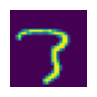

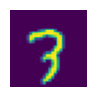

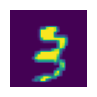

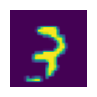

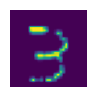

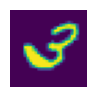

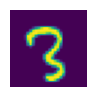

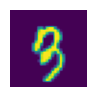

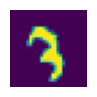

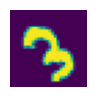

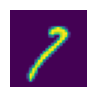

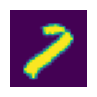

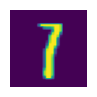

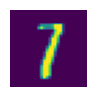

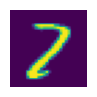

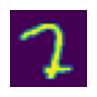

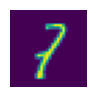

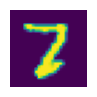

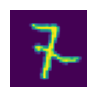

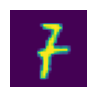

In [79]:
## Analyse the results of gradient descent

# len(range(30)), len(results)
# plt.scatter(range(30), to_np(fr))
## get all predictions using the final values of w and b and round the values to 0 and 1
# p = predictions(train_x, fw, fb)
# p = torch.where((p>0.9), 1, 0)

# print(f'type(p): {p.dtype}, len(p): {len(p)}, p.shape: {p.shape}, p: {p[12:45]}')
# print(f'type(y): {train_y.dtype}, len(y): {len(train_y)}, train_y.shape: {train_y.shape}, y: {train_y[12:23]}')

## find out the indices where p has values of 0
n = 10
d = differs(train_x, train_y, fw, fb)
zeroes = torch.nonzero(d, as_tuple=True)[0]
print(f'top 10 indices where prediction is wrong: {zeroes[0:n]}')
print(f'bottom 10 indices where prediction is wrong: {zeroes[-n:]}')

## find out what y has when p has zeroes, change indices as per result of above code
# print(f'p 13: {p[13].data}, 22: {p[178].data} 34: {p[274].data}')
# print(f'1-p 13: {1-p[13]}, 22: {1-p[178]} 34: {1-p[274]}')
# print(f'y 13: {y[13]}, 22: {y[178]}, 34: {y[274]}')

## find out how many zeroes are there in p
# print(f'number of 1s, 0s in predictions and len(p): {p.sum()}, {(1-p).abs().sum()}, {len(p)}')

# diffs = torch.where(y==1, 1-p, p).abs().sum()
# print(f'preds and y disagree in {diffs} places')

# diff = (p <= 0.5).float().sum()
# type(diff), len(diff), diff.shape, diff
# diff, len(train_y), loss(p, train_y)

# p[0], train_y[0], p[0] - train_y[0]
# diffs = torch.nonzero((p < 0.5).float().unbind(1)[0])
trx = [Image.open(f) for f in (path/'train'/'3').ls().sorted()] + [Image.open(f) for f in (path/'train'/'7').ls().sorted()]
## try = [Image.open(f) for f in (path/'train'/'7').ls().sorted()]

p = predictions(train_x, fw, fb)
p = torch.where((p>0.9), 1, 0)

def images(zeroes, x, p, n):
  ## print indices of images that are 3 but are predicted as not 3 (assuming first 10 incorrect predictions are 3s)
  for d in zeroes[0:n]:
    print(f'd: {d}, wrong predictions: {p[d]}')
    show_image(x[d])

  ## print indices of images that are 7 but are predicted as 3 (assuming last 10 incorrect predictions are 7s)
  for d in zeroes[-n:]:
    print(f'd: {d}, wrong predictions: {p[d]}')
    show_image(x[d])

  # for i in range(0, 5):
  #   print(f'i: {i}, 5 predictions, likely correct: {p[i]}')
  #   show_image(trx[i])

images(zeroes, trx, p, n)


len(y): 12396
preds and valid_y disagree in 31 places after 1000 iteration
d: 3, wrong predictions: tensor([0], device='cuda:0')
d: 15, wrong predictions: tensor([0], device='cuda:0')
d: 31, wrong predictions: tensor([0], device='cuda:0')
d: 59, wrong predictions: tensor([0], device='cuda:0')
d: 69, wrong predictions: tensor([0], device='cuda:0')
d: 123, wrong predictions: tensor([0], device='cuda:0')
d: 152, wrong predictions: tensor([0], device='cuda:0')
d: 185, wrong predictions: tensor([0], device='cuda:0')
d: 214, wrong predictions: tensor([0], device='cuda:0')
d: 309, wrong predictions: tensor([0], device='cuda:0')
d: 1101, wrong predictions: tensor([1], device='cuda:0')
d: 1204, wrong predictions: tensor([1], device='cuda:0')
d: 1337, wrong predictions: tensor([1], device='cuda:0')
d: 1339, wrong predictions: tensor([1], device='cuda:0')
d: 1392, wrong predictions: tensor([1], device='cuda:0')
d: 1450, wrong predictions: tensor([1], device='cuda:0')
d: 1669, wrong predictions: t

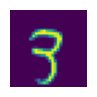

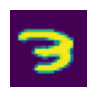

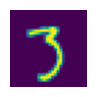

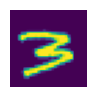

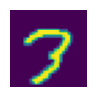

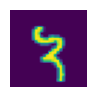

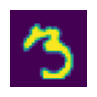

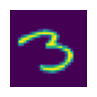

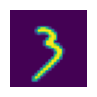

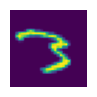

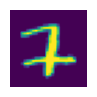

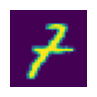

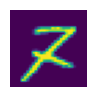

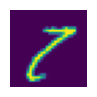

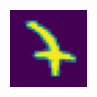

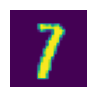

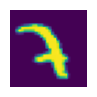

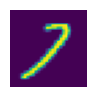

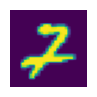

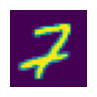

In [63]:
## How does the model work on validation dataset

d = differs(valid_x, valid_y, fw, fb)
zeroes = torch.nonzero(d)
print(f'len(y): {len(train_y)}')
print(f'preds and valid_y disagree in {d.sum()} places after 1000 iteration')

vlx = [Image.open(f) for f in (path/'valid'/'3').ls().sorted()] + [Image.open(f) for f in (path/'valid'/'7').ls().sorted()]
p = predictions(valid_x, fw, fb)
p = torch.where((p>0.9), 1, 0)
images(zeroes, vlx, p, n)

In [64]:
## Rough work from here on

## how do torch.nonzero() and tensor().linspace() work

#??torch.nonzero
t = tensor([0,1,0,2,2,3,0,1,1,1,1])
print(f'nonzero: {torch.nonzero(t)}')

#??torch.linspace
a = torch.linspace(1, 9, steps=9).unsqueeze(1)
print(f'a: {a}, a[0]: {a[0]}, a[1]: {a[1]}, a[0][0]: {a[0][0]}, a[0:3]: {a[0:3]}')

a = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
a[0:3][0:3][0:3], a[0:3, 0:3]
a.sum(), a.sum(0), a.sum(1)

??show_images

nonzero: tensor([[ 1],
        [ 3],
        [ 4],
        [ 5],
        [ 7],
        [ 8],
        [ 9],
        [10]])
a: tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]]), a[0]: tensor([1.]), a[1]: tensor([2.]), a[0][0]: 1.0, a[0:3]: tensor([[1.],
        [2.],
        [3.]])


Signature:
show_images(
    ims,
    nrows=1,
    ncols=None,
    titles=None,
    *,
    figsize: 'tuple' = None,
    imsize: 'int' = 3,
    suptitle: 'str' = None,
    sharex=False,
    sharey=False,
    squeeze=True,
    width_ratios=None,
    height_ratios=None,
    subplot_kw=None,
    gridspec_kw=None,
)
Source:   
@delegates(subplots)
def show_images(ims, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`."
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t)
File:      /opt/conda/lib/python3.11/site-packages/fastai/torch_core.py
Type:      function

In [10]:
print(len(train_x), train_x.shape, type(train_x), len(train_x[0]), '\n', train_x[0:3, 0:7])
print(len(train_y), train_y.shape, type(train_y), len(train_y[0]), train_y[0:3])
print(len(w), w.shape, type(w), len(w[0]), w[0:2, 0:3])
len(b), type(b), b[0:7]

12396 torch.Size([12396, 784]) <class 'torch.Tensor'> 784 
 tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
12396 torch.Size([12396, 1]) <class 'torch.Tensor'> 1 tensor([[1],
        [1],
        [1]], device='cuda:0')
784 torch.Size([784, 1]) <class 'torch.Tensor'> 1 tensor([[1.8423],
        [0.5189]], device='cuda:0', grad_fn=<SliceBackward0>)


(12396,
 torch.Tensor,
 tensor([-0.2476, -0.3517,  0.8259,  0.0914,  0.2466, -0.9449, -0.2818], device='cuda:0', grad_fn=<SliceBackward0>))

In [11]:
## how are gradients tracked
a = torch.ones((4,1), requires_grad=True)
print(f'a: {a}')
print(f'a.grad_fn: {a.grad_fn}')
b = a + 1
print(f'b.grad_fn: {b.grad_fn}')
c = a.sum(1)
print(f'c.grad_fn: {c.grad_fn}')
print(f'c: {c}')
d = c.unsqueeze(1)
print(f'd.grad_fn: {d.grad_fn}')
print(f'd: {d}')

a: tensor([[1.],
        [1.],
        [1.],
        [1.]], requires_grad=True)
a.grad_fn: None
b.grad_fn: <AddBackward0 object at 0x7f56835dd780>
c.grad_fn: <SumBackward1 object at 0x7f56835dd780>
c: tensor([1., 1., 1., 1.], grad_fn=<SumBackward1>)
d.grad_fn: <UnsqueezeBackward0 object at 0x7f56835ddf30>
d: tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<UnsqueezeBackward0>)
